In [395]:
# elasticsearch support
from elasticsearch5 import Elasticsearch
from elasticsearch5 import helpers

# utility includes
from collections import Counter
import argparse
import json
import math
import pprint
import re
import sys

# analysis / visualizations
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# geovisualization
from shapely.geometry import Point
import descartes
import geopandas as gpd


ES = Elasticsearch()

indexName = 'logstash-test8'

pd.options.display.float_format = '{:.2f}'.format


In [274]:
# Create an index in ES with a given mapping. The most important point here is to
# set the correct data types for the document properties, since they are immutable
# once set -- to change one, you must create a new index with the new datatype and
# re-insert all of the the content into the new index.

def init_index(index_name):
    index_config = {
        "mappings": {
            "doc" : {
                "properties": {
                    "sessionId": {"type": "keyword"},
                    "recordType": {"type": "keyword"},
                    "userAgent": {"type": "keyword"},
                    "pid": {"type": "keyword"},
                    "nodeId": {"type": "keyword"},
                    "event": {"type": "keyword"}
                }
            }
        }
    }

    try:
        ES.indices.create(index_name, index_config)
    except Exception as e:
        print e
        return 1
    return 0


In [276]:
# Create the index

print init_index(indexName)

0


In [361]:
# Get the list of elasticsearch results for paginated queries for unique fields plus event counts.
# This function uses the "composite aggregation" feature of ES, the recommended way to paginate
# all buckets from an aggregation efficiently:
# https://www.elastic.co/guide/en/elasticsearch/reference/current/search-aggregations-bucket-composite-aggregation.html
# Elasticsearch 'date math' specifications:
# https://www.elastic.co/guide/en/elasticsearch/reference/current/common-options.html#date-math
#
# index_name -- string name of the elasticsearch index
# fields     -- list of elasticsearch-formatted fields as returned by build_es_fields_list()
# date_range -- dictionary of elasticsearch date math (default today - 1 month)
# must       -- additional must clause(s) for the bool section
# sub_agg    -- sub-aggregation for further dividing the comp_agg into buckets
# page_size  -- integer number of records for each page of results (default 1000)

def get_composite_aggregation_results(index_name, fields, date_range=None, must=None, sub_agg=None, page_size=1000):
    search_body = {
        'track_total_hits': 'false',
        'size': '0',
        'query': {
            'bool': {
                'must_not': {
                    'term': {
                        'tags': 'dataone_ip'
                    }
                },
                'must': [{
                    'range' : {
                        '@timestamp' : {
                            'gte' : 'now-1M/d',
                            'lt' :  'now/d'
                        }
                    }}]
            }
        },
        'aggs' : {
            'comp_agg' : {
                'composite' : {
                    'size': page_size,
                    'sources' : fields
                }
            }
        }    
    }

    if date_range:
        search_body['query']['bool']['must'][0]['range']['@timestamp'] = date_range
        
    if must:
        search_body['query']['bool']['must'].append(must)
    
    if sub_agg:
        search_body['aggs']['comp_agg']['aggs'] = sub_agg

    #pprint.pprint(search_body)
    
    results = []

    # prime the pagination with the first page query and get the number of records (buckets) returned
    result = ES.search(index=index_name, body=search_body)
    bucketcount = len(result['aggregations']['comp_agg']['buckets'])

    # continue the pagination as long as records continue to be returned
    while bucketcount > 0:
        results.append(result)
    
        # add the new after_key to the searchbody 
        after = {'after' : result['aggregations']['comp_agg']['after_key']}
        search_body['aggs']['comp_agg']['composite'].update(after)
    
        # grab the next page of results and update the count
        result = ES.search(index=index_name, body=search_body)
        bucketcount = len(result['aggregations']['comp_agg']['buckets'])

    return results


In [77]:
# Convert a string dicitonary of fields and aliases into an elasticsearch list of field dictionaries

def build_es_fields_list(fields_dict):
    es_fields_list = []
    for k,v in fields_dict.items():
        es_fields_list.append({ v: { 'terms' : { 'field': k } } })
    return es_fields_list


In [307]:
# Simplify a list of elasticsearch results into a list of dictionaries of fields
# dictionary keys will be all keys in the bucket plus 'count', the doc_count value from the bucket
# a sub-aggregation will be inside its own dict

def es_result_to_dicts(data):
    data_dict_list = []
    
    for result in data:
        for bucket in result['aggregations']['comp_agg']['buckets']:
            event_dict = {}
            for item in bucket['key']:
                event_dict[item] = bucket['key'][item]
            event_dict['count'] = bucket['doc_count']
            
            if bucket.get('sub-agg'):
                sub_dict = {}
                for sub_item in bucket['sub-agg']['buckets']:
                    sub_dict[sub_item['key']] = sub_item['doc_count']
                event_dict['sub-agg'] = sub_dict

            data_dict_list.append(event_dict)
    
    return data_dict_list


         count
count  2748.00
mean     25.07
std     369.60
min       1.00
25%       2.00
50%       3.00
75%       9.00
max   14424.00
      count                                    sessionId
1         1  00365441e78300fa749cdc6e7f3fcd8e|2019031314
8         1  00ef7cc3845aedef3f9913b4b86d8f5a|2019031205
9         1  00ef7cc3845aedef3f9913b4b86d8f5a|2019031211
13        1  01e2fb5aebf7dc4bff680965e76a5622|2019030713
14        1  01f41a147064475547f7d255b9a4f164|2019031322
15        1  022f0ddab18b0bc9381102229c8ce439|2019031319
16        1  022f0ddab18b0bc9381102229c8ce439|2019031320
19        1  0239f95de9d104eb1fedf628596d8a74|2019032517
20        1  025b021fa1a8ec3a27b7136d29b0036c|2019031611
22        1  0269f78c5a64bc6146402fbd559383cb|2019032117
36        1  02bd9f0e576cd38ee3c2f7126a2ea32d|2019031122
37        1  02bd9f0e576cd38ee3c2f7126a2ea32d|2019031123
38        1  030416313cd8da246224b7806a928d92|2019030721
39        1  030416313cd8da246224b7806a928d92|2019030722
40        

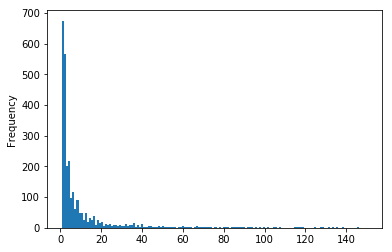

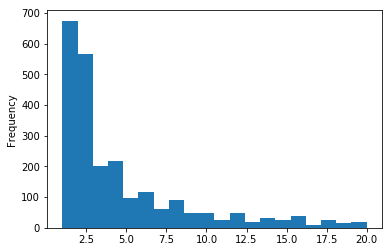

In [354]:
# Show some descriptive statistics of the number of events per session

date_range = {'gte': 'now-1M/d', 'lt': 'now/d'}

fields = {'sessionId': 'sessionId'}

fields = build_es_fields_list(fields)

data = get_composite_aggregation_results(indexName, fields, date_range)

data_list = es_result_to_dicts(data)

df = pd.DataFrame(data_list)

print df.describe()
print df.sort_values(['count', 'sessionId'])


# frequency table of number of events per session
# pandas abbreviates the list, but the full list can be displayed using print_full, below

#def print_full(x):
#    pd.set_option('display.max_rows', len(x))
#    print(x)
#    pd.reset_option('display.max_rows')
#print_full(df.sort_values(['count', 'sessionId']))


# histogram of number of events per session (events <= 150)
plt.hist(df['count'], range=[1, 150], bins=150)
plt.ylabel('Frequency')
plt.show()

# histogram of number of events per session (events <= 20)
plt.hist(df['count'], range=[1, 20], bins=20)
plt.ylabel('Frequency')
plt.show()


In [355]:
# Perform some basic analysis of the number of unique visitors:
# how many are there?
# how many events do they create?

date_range = {'gte': 'now-1M/d', 'lt': 'now/d'}

fields = {'geoip.ip': 'ip'}

fields = build_es_fields_list(fields)

data = get_composite_aggregation_results(indexName, fields, date_range)

data_list = es_result_to_dicts(data)

df = pd.DataFrame(data_list)

print df.describe()
print df.sort_values(['count', 'ip'])


         count
count  1080.00
mean     60.50
std     988.01
min       1.00
25%       2.00
50%       4.00
75%      13.00
max   30640.00
      count               ip
518       1  104.154.120.187
537       1    109.92.83.202
542       1  111.206.198.120
545       1  114.124.147.167
546       1   115.132.159.79
554       1  125.209.235.168
556       1  125.209.235.172
557       1  125.209.235.174
558       1  125.209.235.182
613       1   128.227.209.95
564       1    128.30.51.199
642       1  129.186.252.177
23        1    13.230.26.220
660       1   130.95.254.102
662       1   130.95.254.191
685       1  131.114.235.113
699       1  132.198.154.228
718       1   134.184.254.99
746       1   138.23.233.166
759       1  140.160.182.128
795       1  148.231.210.138
797       1  148.231.210.195
806       1  148.231.210.205
810       1    148.251.50.77
811       1    148.251.75.46
815       1   149.43.165.225
814       1    149.43.165.93
816       1   149.43.166.177
817       1   149.43.166

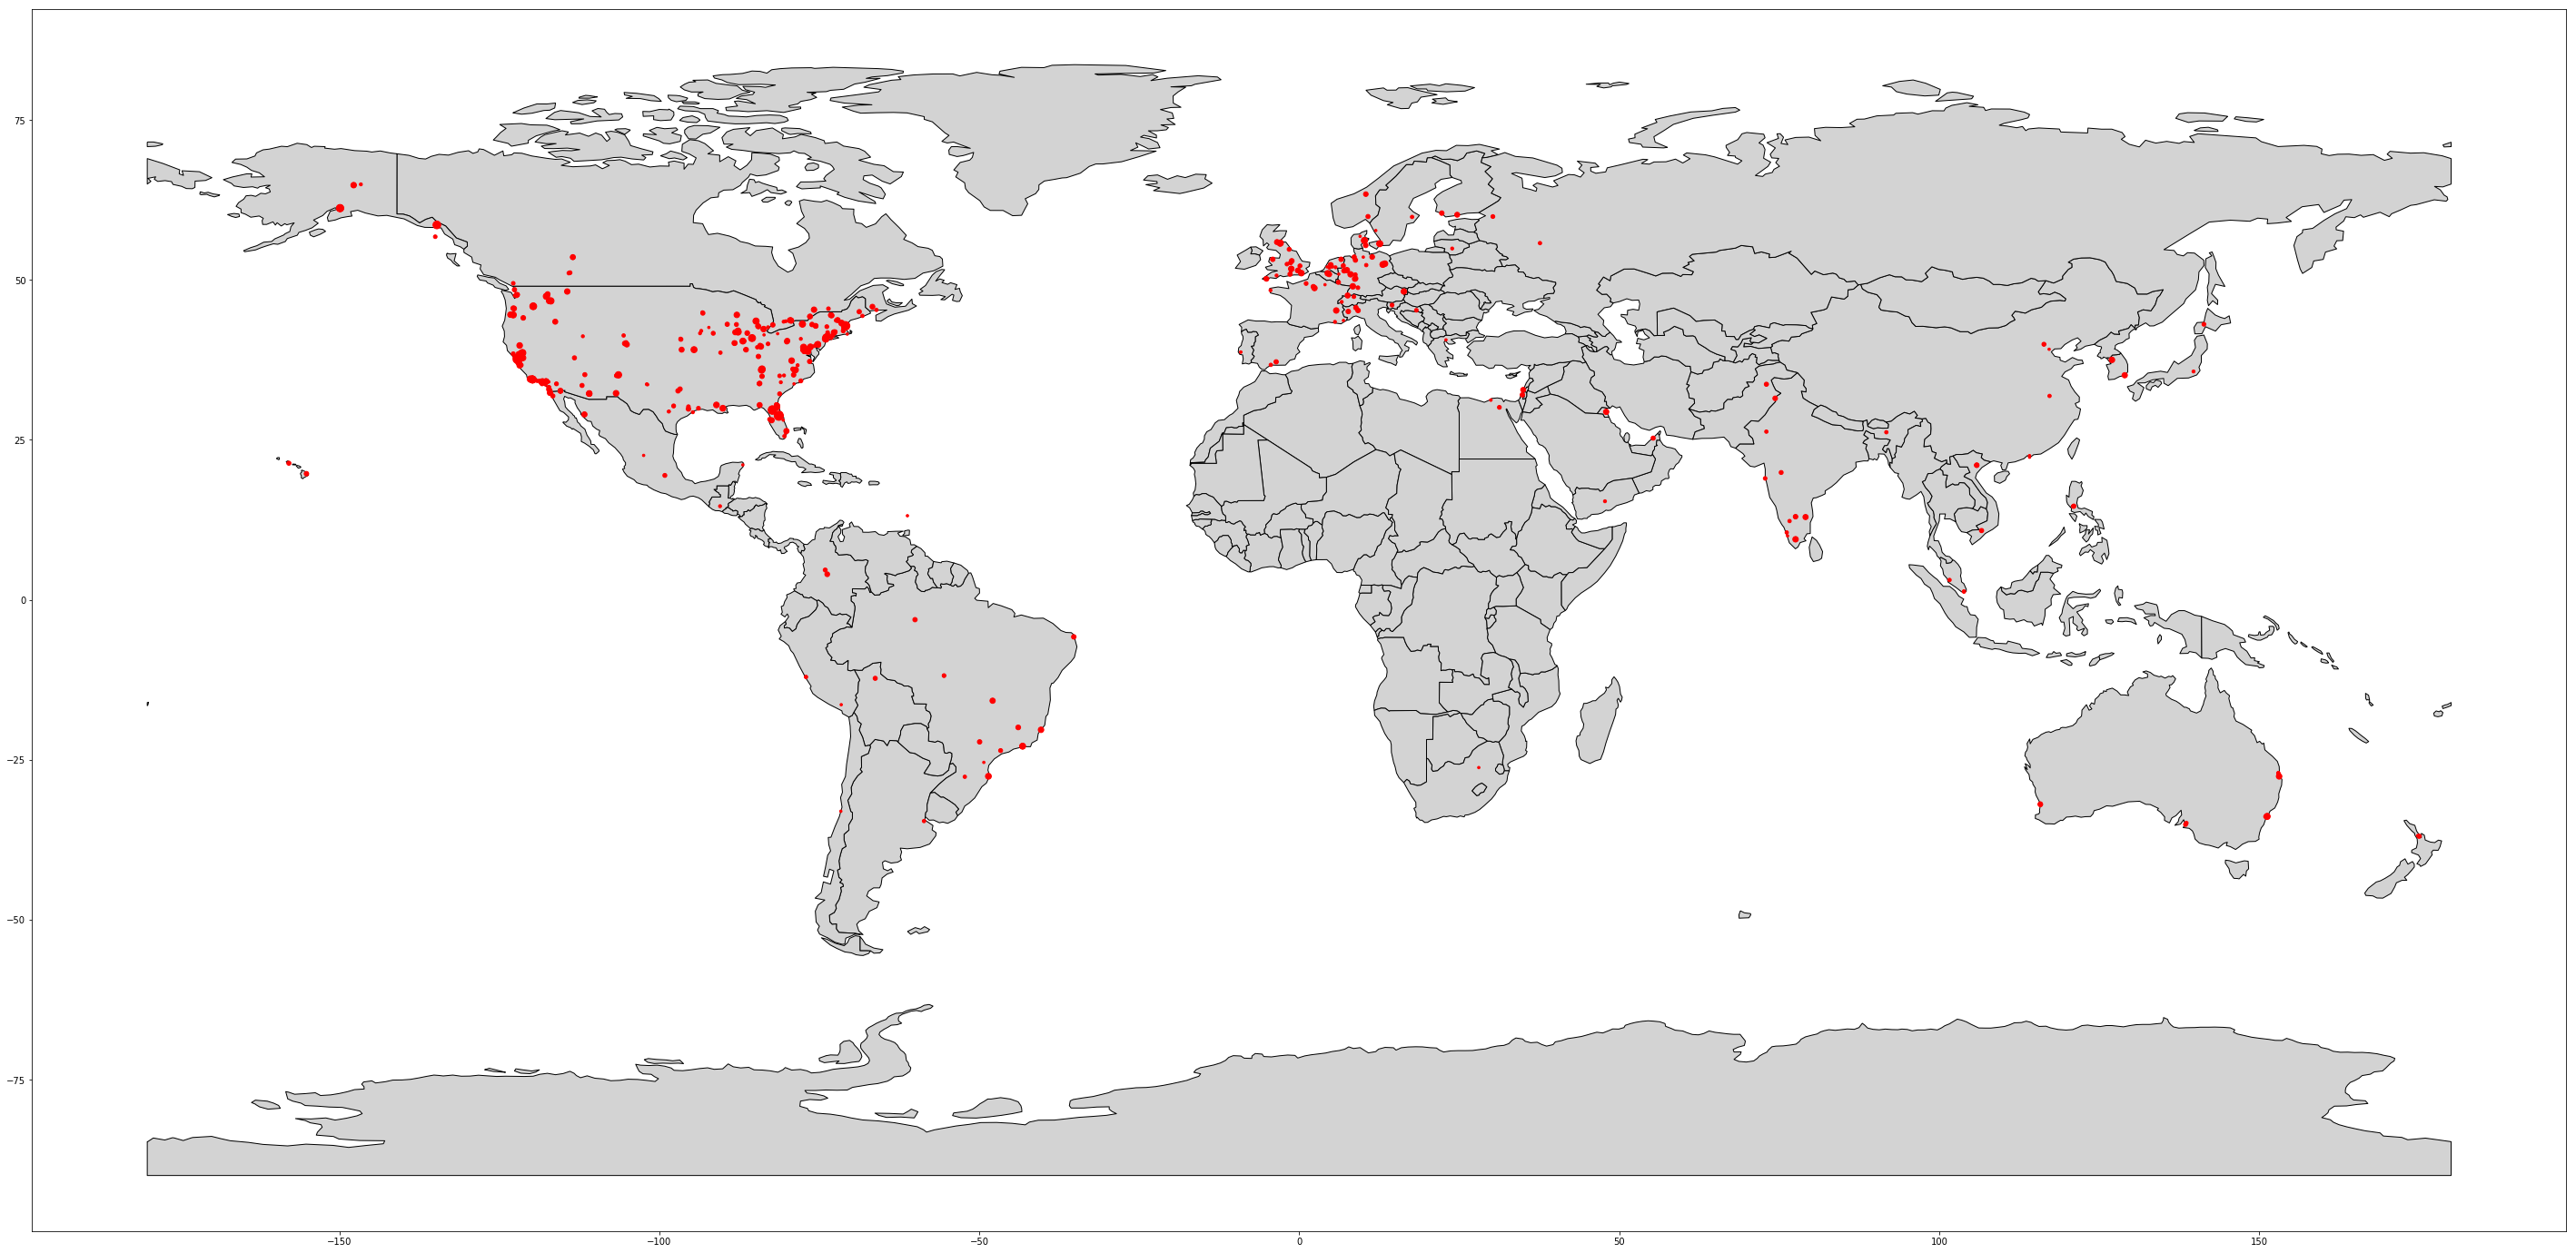

In [356]:
# Plot the geolocated session ips on a world map. These are the locations from which users
# are accessing DataONE, not necessarily the location of data they search for.

date_range = {'gte': 'now-1M/d', 'lt': 'now/d'}

#fields = ['geoip.ip', 'geoip.latitude', 'geoip.longitude', 'geoip.region_name.keyword']
fields = {'geoip.ip': 'ip',
          'geoip.latitude': 'latitude',
          'geoip.longitude': 'longitude',
          'geoip.region_name.keyword': 'region_name'}

fields = build_es_fields_list(fields)

data = get_composite_aggregation_results(indexName, fields, date_range)

data_list = es_result_to_dicts(data)

df = pd.DataFrame(data_list)
df['count']=df['count'].apply(lambda x:math.log(x)*10)

path = gpd.datasets.get_path('naturalearth_lowres')
basemap = gpd.read_file(path)
fig,ax = plt.subplots(figsize = (50,50))
basemap.plot(ax=ax, color='lightgrey', edgecolor='black')

crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip( df['longitude'], df['latitude'])]
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
geo_df.plot(ax=ax, markersize=geo_df['count'], color='red', marker='o')

# labelling isn't great at the moment; labels overlap
#labels = set()
#for longitude, latitude, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df.label):
#    if not label in labels:
#        ax.annotate(label, xy=(longitude, latitude), xytext=(3, 3), textcoords="offset points")
#        labels.add(label)



     count                                                  q
156      1                 " air quality milan"+"air quality"
314      1                         "2008 recession"+recession
370      1                                  "Air composition"
68       1                         "Air composition"+Aerosols
242      1                               "Busse and Gröning "
108      1              "Busse and Gröning "+"resource curse"
345      1                                    "CO2 emissions"
45       1                                "CO2 emissions"+CO2
218      1                                    "Caribbean Sea"
134      1                                "Catalogue of Life"
157      1                                     "Indian Ocean"
129      1                   "Interagency Ecological Program"
249      1  "Interagency Ecological Program"+"Interagency ...
103      1                          "Moored Temperature Data"
220      1                                   "PISCO subtidal"
269     

(-0.5, 399.5, 199.5, -0.5)

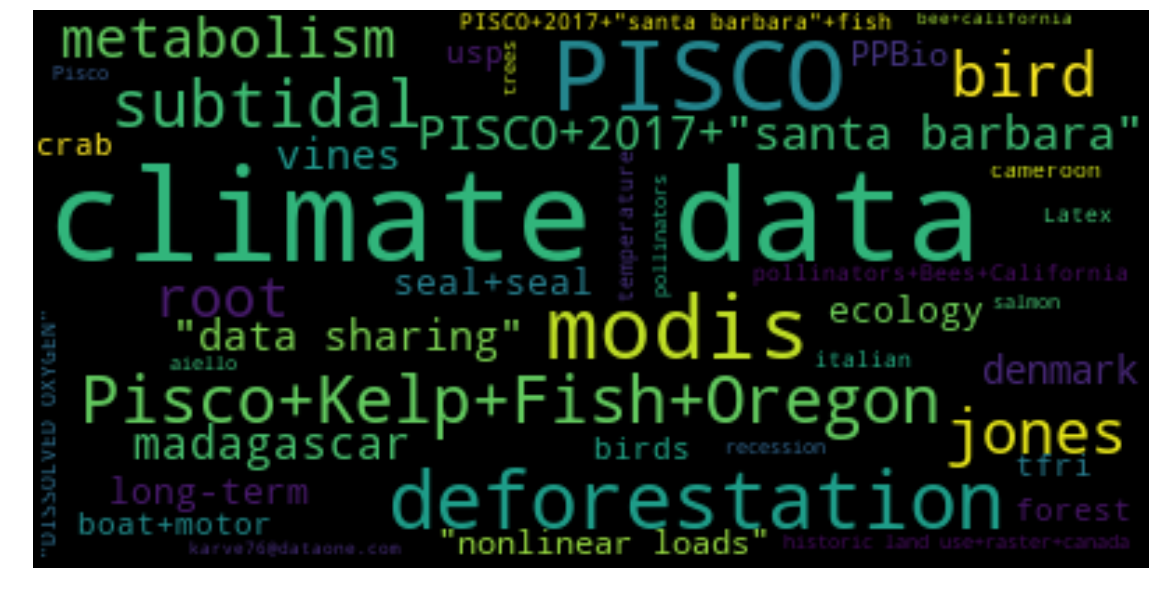

In [357]:
# Create a word cloud of search terms

date_range = {'gte': 'now-1M/d', 'lt': 'now/d'}

fields = {'queryParts.q.keyword': 'query_term'}

fields = build_es_fields_list(fields)

data = get_composite_aggregation_results(indexName, fields, date_range)

data_list = es_result_to_dicts(data)

query_terms = {}
for item in data_list:
    r = re.search('obsoletedBy:\*\+(.*)\+formatType:', item['query_term'])
    
    if r:
        query_term = r.group(1).encode('utf-8')
        if query_term in query_terms.keys():
            query_terms[query_term] = query_terms[query_term] + item['count']
        else:
            query_terms[query_term] = item['count']
query_list = []
for k,v in query_terms.items():
    query_list.append({'count': v, 'q': k})

df = pd.DataFrame(query_list)

#print df.describe()
print df.sort_values(['count', 'q'])

# display a word cloud of the search terms
freqs = Counter(query_terms)
tuples = [tuple(x) for x in freqs]
wordcloud = WordCloud().generate_from_frequencies(freqs)
plt.figure(figsize = (20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [358]:
# Descriptive statistics and frequency table for downloaded pids

date_range = {'gte': 'now-1M/d', 'lt': 'now/d'}

fields = {'pid.keyword': 'pid'}

fields = build_es_fields_list(fields)

must = { 'term': {'event': 'read'} }

data = get_composite_aggregation_results(indexName, fields, date_range, must)

data_list = es_result_to_dicts(data)

df = pd.DataFrame(data_list)

print df.describe()

print df.sort_values(['count', 'pid'])


         count
count 18006.00
mean      2.45
std       2.13
min       1.00
25%       1.00
50%       1.00
75%       4.00
max      58.00
       count                                                pid
3491       1                                       AKCRRAB.10.4
3492       1                                       AKCRRAB.12.2
3493       1                                       AKCRRAB.13.3
3494       1                                       AKCRRAB.36.1
3495       1                                        AKCRRAB.6.4
3496       1                                        AKCRRAB.8.3
3497       1                                        Akasha.16.5
3498       1                                        Akasha.16.6
3499       1                                        Akasha.16.9
3500       1                                       Blandy.235.1
3501       1                                       Blandy.246.3
3502       1                                        Blandy.25.2
3503       1                     

In [359]:
# Descriptive statistics and frequency table for user agents

date_range = {'gte': 'now-1M/d', 'lt': 'now/d'}

fields = {'userAgent.keyword': 'user_agent'}

fields = build_es_fields_list(fields)

data = get_composite_aggregation_results(indexName, fields, date_range)

data_list = es_result_to_dicts(data)

df = pd.DataFrame(data_list)

print df.describe()

print df.sort_values(['count', 'user_agent'])


         count
count   269.00
mean    256.08
std    1999.27
min       1.00
25%       4.00
50%      16.00
75%      62.00
max   30793.00
     count                                         user_agent
5        1                                Googlebot-Image/1.0
17       1  Mozilla/5.0 (Linux; Android 7.1.2; Redmi 4A) A...
21       1  Mozilla/5.0 (Linux; Android 9; ONEPLUS A6000) ...
24       1  Mozilla/5.0 (Linux; Android 9; SM-N960F) Apple...
61       1  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_1...
85       1  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_1...
102      1  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...
104      1  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8) A...
105      1  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_2)...
108      1  Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....
109      1  Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...
128      1  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
151      1  Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6.

In [393]:

def get_session_events(indexname, sessionid, fields = None, page_size=100):
    search_body = {
        "from": 0,
        "size": page_size,
        "_source": [
            "_id",
            "@timestamp",
            "sessionId",
            "event",
            "xgeoip",
            "recordType",
            "status",
            "request",
            "formatType",
            "formatId"
        ],
        "query": {
            "bool": {
                "must": [
                    {
                        "exists": {
                            "field": "sessionId"
                        }
                    },
                    {
                        "match_phrase": {
                            "sessionId": {
                                "query": sessionid
                            }
                        }
                    },
                ]
            }
        },
        "sort": [ 
            {
                "@timestamp": {
                    "order": "asc",
                    "unmapped_type": "date"
                }
            }
        ]
    }

    # if a fields collection was passed in, overwrite the default fields encoded in the query
    if fields:
        searchbody["_source"] = fields
    
    data = []

    events = ES.search(index=indexname, body=search_body)

    data.append(events)
    
    event_count = events['hits']['total']
    from_rec = 0
    for f in range(page_size, event_count, page_size):
        from_rec = from_rec + page_size
        search_body['from'] = from_rec
        
        events = ES.search(index=indexname, body=search_body)
        data.append(events)

    return data

In [394]:
# get a list of 'interesting' sessions -- those sessions with both 'read' and 'search' activity

date_range = {'gte': 'now-1M/d', 'lt': 'now'}

fields = {'sessionId': 'sessionId'}

fields = build_es_fields_list(fields)

#fixme: change this to read, search for the newer index
must = { 'terms': {'event': ['read', 'update']} }

sub_agg = { 'sub-agg': { 'terms': { 'field': 'event.keyword'} } }

data = get_composite_aggregation_results(indexName, fields, date_range, must, sub_agg)
#pprint.pprint(data)

data_list = es_result_to_dicts(data)

interesting_sessions = []

for i in data_list:
    if i['sub-agg'].get('read') and i['sub-agg'].get('update'):
        #pprint.pprint(i)
        interesting_sessions.append(i['sessionId'])
        
#pprint.pprint(interesting_sessions)

for s in interesting_sessions:
    print s
    pprint.pprint(get_session_events(indexName, s))



1221a793f1441ec6c039227cb05c4965|2019031313
[{u'_shards': {u'failed': 0, u'skipped': 0, u'successful': 5, u'total': 5},
  u'hits': {u'hits': [{u'_id': u'CrNsfWkBGmu4B0KUDpic',
                       u'_index': u'logstash-test8',
                       u'_score': None,
                       u'_source': {u'@timestamp': u'2019-03-13T13:54:36.683Z',
                                    u'event': u'read',
                                    u'formatId': u'eml://ecoinformatics.org/eml-2.1.1',
                                    u'formatType': u'METADATA',
                                    u'recordType': u'eventlog',
                                    u'sessionId': u'1221a793f1441ec6c039227cb05c4965|2019031313'},
                       u'_type': u'doc',
                       u'sort': [1552485276683]},
                      {u'_id': u'C7NsfWkBGmu4B0KUDpic',
                       u'_index': u'logstash-test8',
                       u'_score': None,
                       u'_source': {u'@ti

                                    u'event': u'read',
                                    u'formatId': u'eml://ecoinformatics.org/eml-2.1.1',
                                    u'formatType': u'METADATA',
                                    u'recordType': u'eventlog',
                                    u'sessionId': u'1221a793f1441ec6c039227cb05c4965|2019031314'},
                       u'_type': u'doc',
                       u'sort': [1552485821600]},
                      {u'_id': u'FrNsfWkBGmu4B0KUDpYw',
                       u'_index': u'logstash-test8',
                       u'_score': None,
                       u'_source': {u'@timestamp': u'2019-03-13T14:03:50.498Z',
                                    u'event': u'read',
                                    u'formatId': u'eml://ecoinformatics.org/eml-2.1.1',
                                    u'formatType': u'METADATA',
                                    u'recordType': u'eventlog',
                                    u's

[{u'_shards': {u'failed': 0, u'skipped': 0, u'successful': 5, u'total': 5},
  u'hits': {u'hits': [{u'_id': u'pLeSgmkBGmu4B0KUcNOo',
                       u'_index': u'logstash-test8',
                       u'_score': None,
                       u'_source': {u'@timestamp': u'2019-03-14T17:06:21.803Z',
                                    u'event': u'updateSystemMetadata',
                                    u'formatId': u'eml://ecoinformatics.org/eml-2.1.1',
                                    u'formatType': u'METADATA',
                                    u'recordType': u'eventlog',
                                    u'sessionId': u'4bb5e17597f7cc3674608ddeaaa4776b|2019031417'},
                       u'_type': u'doc',
                       u'sort': [1552583181803]},
                      {u'_id': u'pbeSgmkBGmu4B0KUcNOo',
                       u'_index': u'logstash-test8',
                       u'_score': None,
                       u'_source': {u'@timestamp': u'2019-03-14T17:06

[{u'_shards': {u'failed': 0, u'skipped': 0, u'successful': 5, u'total': 5},
  u'hits': {u'hits': [{u'_id': u'KbeSgmkBGmu4B0KUdNv-',
                       u'_index': u'logstash-test8',
                       u'_score': None,
                       u'_source': {u'@timestamp': u'2019-03-14T20:16:15.931Z',
                                    u'event': u'read',
                                    u'formatId': u'eml://ecoinformatics.org/eml-2.1.1',
                                    u'formatType': u'METADATA',
                                    u'recordType': u'eventlog',
                                    u'sessionId': u'4bb5e17597f7cc3674608ddeaaa4776b|2019031420'},
                       u'_type': u'doc',
                       u'sort': [1552594575931]},
                      {u'_id': u'_reSgmkBGmu4B0KUddsM',
                       u'_index': u'logstash-test8',
                       u'_score': None,
                       u'_source': {u'@timestamp': u'2019-03-14T20:16:56.461Z',
     

[{u'_shards': {u'failed': 0, u'skipped': 0, u'successful': 5, u'total': 5},
  u'hits': {u'hits': [{u'_id': u'U7eSgmkBGmu4B0KUcthK',
                       u'_index': u'logstash-test8',
                       u'_score': None,
                       u'_source': {u'@timestamp': u'2019-03-14T22:26:38.558Z',
                                    u'event': u'read',
                                    u'formatId': u'eml://ecoinformatics.org/eml-2.1.1',
                                    u'formatType': u'METADATA',
                                    u'recordType': u'eventlog',
                                    u'sessionId': u'4bb5e17597f7cc3674608ddeaaa4776b|2019031422'},
                       u'_type': u'doc',
                       u'sort': [1552602398558]},
                      {u'_id': u'ZLeSgmkBGmu4B0KUcthK',
                       u'_index': u'logstash-test8',
                       u'_score': None,
                       u'_source': {u'@timestamp': u'2019-03-14T22:28:39.715Z',
     

[{u'_shards': {u'failed': 0, u'skipped': 0, u'successful': 5, u'total': 5},
  u'hits': {u'hits': [{u'_id': u'JLeSgmkBGmu4B0KUcthK',
                       u'_index': u'logstash-test8',
                       u'_score': None,
                       u'_source': {u'@timestamp': u'2019-03-14T23:00:28.719Z',
                                    u'event': u'read',
                                    u'formatId': u'eml://ecoinformatics.org/eml-2.1.1',
                                    u'formatType': u'METADATA',
                                    u'recordType': u'eventlog',
                                    u'sessionId': u'4bb5e17597f7cc3674608ddeaaa4776b|2019031423'},
                       u'_type': u'doc',
                       u'sort': [1552604428719]},
                      {u'_id': u'greSgmkBGmu4B0KUcthK',
                       u'_index': u'logstash-test8',
                       u'_score': None,
                       u'_source': {u'@timestamp': u'2019-03-14T23:01:53.739Z',
     

                       u'sort': [1552423814664]},
                      {u'_id': u'o69FeGkBGmu4B0KUq0iD',
                       u'_index': u'logstash-test8',
                       u'_score': None,
                       u'_source': {u'@timestamp': u'2019-03-12T20:50:17.233Z',
                                    u'event': u'update',
                                    u'formatId': u'eml://ecoinformatics.org/eml-2.1.1',
                                    u'formatType': u'METADATA',
                                    u'recordType': u'eventlog',
                                    u'sessionId': u'4e8441e482301409ff11d645cfa17633|2019031220'},
                       u'_type': u'doc',
                       u'sort': [1552423817233]},
                      {u'_id': u'Jq9FeGkBGmu4B0KUq0h1',
                       u'_index': u'logstash-test8',
                       u'_score': None,
                       u'_source': {u'@timestamp': u'2019-03-12T20:50:17.579Z',
                             

                       u'_source': {u'@timestamp': u'2019-03-13T08:20:11.021Z',
                                    u'event': u'read',
                                    u'formatId': u'http://www.openarchives.org/ore/terms',
                                    u'formatType': u'RESOURCE',
                                    u'recordType': u'eventlog',
                                    u'sessionId': u'68c64c415ba95b2a6a33e09649536680|2019031308'},
                       u'_type': u'doc',
                       u'sort': [1552465211021]},
                      {u'_id': u'0LNsfWkBGmu4B0KUC46D',
                       u'_index': u'logstash-test8',
                       u'_score': None,
                       u'_source': {u'@timestamp': u'2019-03-13T08:20:11.070Z',
                                    u'event': u'read',
                                    u'formatId': u'eml://ecoinformatics.org/eml-2.1.1',
                                    u'formatType': u'METADATA',
                    

[{u'_shards': {u'failed': 0, u'skipped': 0, u'successful': 5, u'total': 5},
  u'hits': {u'hits': [{u'_id': u'npHIbWkBGmu4B0KUjYrA',
                       u'_index': u'logstash-test8',
                       u'_score': None,
                       u'_source': {u'@timestamp': u'2019-03-08T23:10:21.324Z',
                                    u'event': u'updateSystemMetadata',
                                    u'formatId': u'eml://ecoinformatics.org/eml-2.1.1',
                                    u'formatType': u'METADATA',
                                    u'recordType': u'eventlog',
                                    u'sessionId': u'a35e5bf4c42bebbaa7c43987d4e1abd2|2019030823'},
                       u'_type': u'doc',
                       u'sort': [1552086621324]},
                      {u'_id': u'cHk9YGkBGmu4B0KUZimS',
                       u'_index': u'logstash-test8',
                       u'_score': None,
                       u'_source': {u'@timestamp': u'2019-03-08T23:10